In [20]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost

In [21]:
path = "C:/Users/74279/PycharmProjects/NBA2K-Ratings/Data/"

In [22]:
stats = pd.read_csv(path+'2015-2022 NBA Player Stats.csv')
stats = stats.iloc[:,1:]
stats = stats[stats.GP > 41]

In [23]:
x = stats.iloc[:,5:22]
x = x.drop(["MPG","MIN","USG","FTA"],axis=1)
y = stats.iloc[:,-1:]
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, random_state=671)

In [24]:
#Linear Regression

from sklearn.linear_model import LinearRegression
Linreg = LinearRegression()
#Fit the model
Linreg.fit(x_train,y_train)
print(mae(Linreg.predict(x_train),y_train))
print(mae(Linreg.predict(x_test),y_test))

1.4747967659436991
1.444135184121736


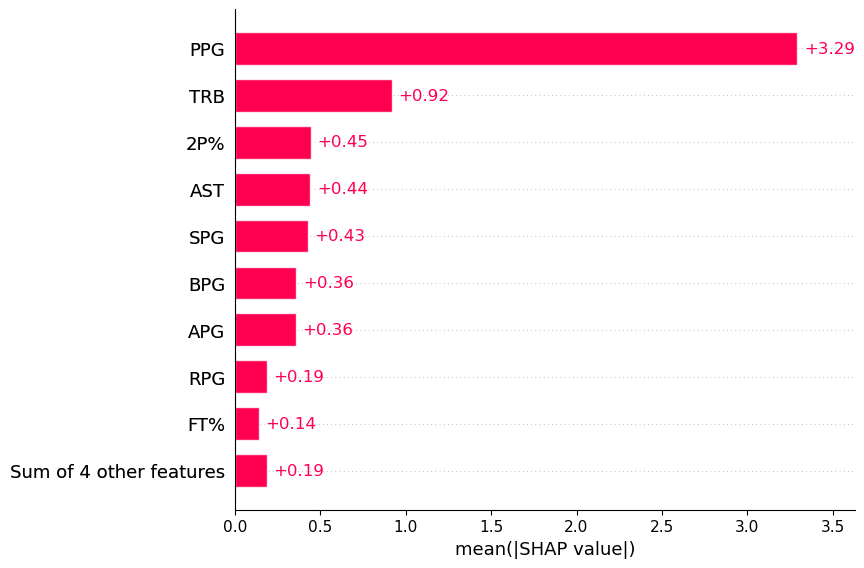

In [25]:
x_train = pd.DataFrame(x_train)
x_train.columns = x.columns
explainer = shap.Explainer(Linreg, x_train)
shap_values = explainer(x_train)
shap.plots.bar(shap_values)

In [26]:
#Lasso Regression with cross-validation
from sklearn.linear_model import LassoCV
Lasreg = LassoCV(cv=10, random_state=0).fit(x,np.array(y))
print(mae(np.round(Lasreg.predict(x)),np.array(y)))

coeff_df = pd.DataFrame(x.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(Lasreg.coef_)

#coeff_df.sort_values(by='Correlation', ascending=False)


1.636218799787573


In [27]:
#Ridge Regression
from sklearn.linear_model import RidgeCV
Ridreg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x, y)
print(mae(np.round(Ridreg.predict(x)),np.array(y)))

coeff_df = pd.DataFrame(x.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(Ridreg.coef_[0])

print(coeff_df.sort_values(by='Correlation', ascending=False))

1.4482209240573554
   Feature  Correlation
2      2P%     8.574043
0      FT%     1.683567
11     BPG     1.363783
10     SPG     1.291735
4      3P%     0.706346
5      PPG     0.641657
8      APG     0.359131
7      TRB     0.240369
9      AST     0.035635
12     VIV     0.006426
3      3PA     0.000530
1      2PA     0.000217
6      RPG    -0.091487


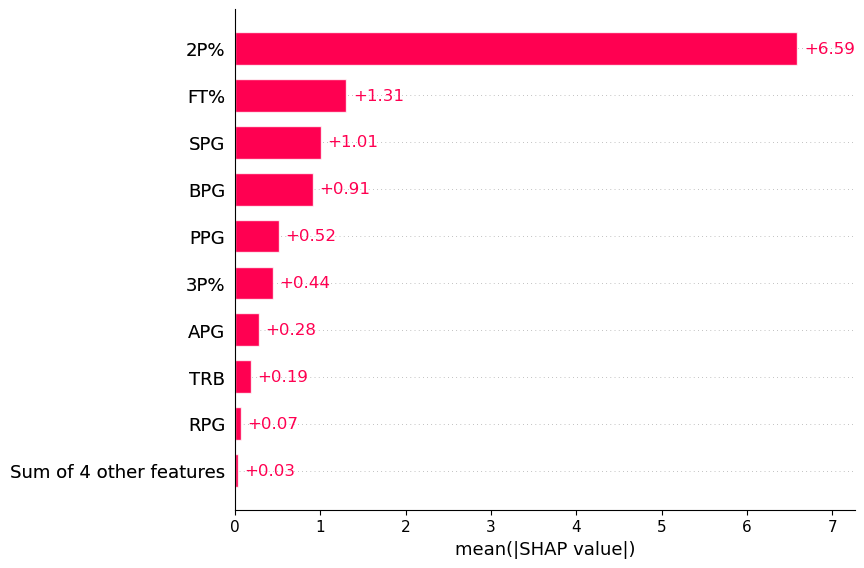

In [28]:
x_train = pd.DataFrame(x_train)
x_train.columns = x.columns
explainer = shap.Explainer(Ridreg, x_train)
shap_values = explainer(x_train)
shap.plots.bar(shap_values)

In [29]:
#SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVR
SVRreg = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.1,cache_size=1000)
#SVRreg = SVR(kernel="linear",cache_size=1000)
SVRreg.fit(x_train,y_train)
print(mae(SVRreg.predict(x_train),y_train))
print(mae(SVRreg.predict(x_test),y_test))

1.4683625680876797
1.4300528025963186


In [30]:
#MLP
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPRegressor
MLPreg = MLPRegressor(random_state=1, max_iter=1000)
MLPreg.fit(x_train,y_train)
print(mae(MLPreg.predict(x_train),y_train))
print(mae(MLPreg.predict(x_test),y_test))

1.1576149366180883
1.5452979713033839


In [31]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(max_depth=20, random_state=0)
RFreg.fit(x_train,y_train)
print(RFreg.score(x_train,y_train))
print(RFreg.score(x_test,y_test))
print(mae(RFreg.predict(x_train),y_train))
print(mae(RFreg.predict(x_test),y_test))

0.9845351061235416
0.8839538937516885
0.5241568224846559
1.4244722559793772


In [32]:
#SHAP chart
explainer = shap.TreeExplainer(RFreg)
shap_values = explainer.shap_values(x_train)

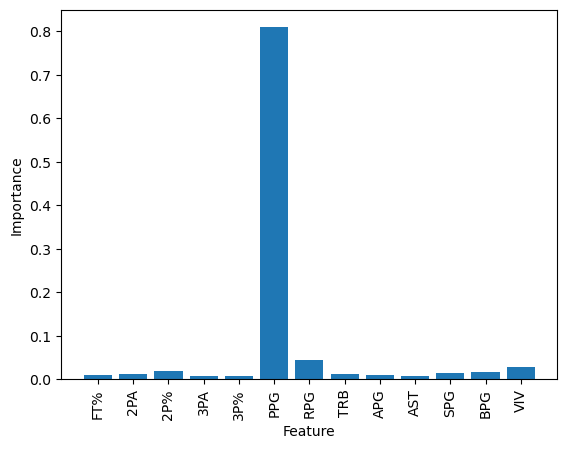

In [33]:
# Create a feature importance plot
plt.bar(range(x.shape[1]), RFreg.feature_importances_)
plt.xticks(range(x.shape[1]), x.columns, rotation=90)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()
#PPG takes up most of the importance

In [34]:
#Crazy! This is not reasonable

In [35]:
#Rebound and assist are also important in reflecting a player's influence on the game. 
#However, we see that no Andre Drummond, the king of rebound, was only rated 87.
stats.sort_values(by="BPG",ascending=False)

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN,USG,FTA,FT%,...,3P%,PPG,RPG,TRB,APG,AST,SPG,BPG,VIV,RATING
2769,Hassan Whiteside,Mia,C,26.00,73,29.1,60.7,20.7,329,0.650,...,0.000,14.2,11.8,23.1,0.4,2.4,0.60,3.68,5.6,85
818,Myles Turner,Ind,C-F,25.15,47,31.0,64.5,16.4,142,0.782,...,0.335,12.6,6.5,11.4,1.0,4.4,0.85,3.38,5.6,79
1369,Hassan Whiteside,Por,C,31.17,67,30.0,62.4,19.6,239,0.686,...,0.571,15.5,13.5,23.6,1.2,5.9,0.39,2.93,8.4,83
394,Myles Turner,Ind,C-F,26.05,42,29.4,61.2,17.1,105,0.752,...,0.333,12.9,7.1,13.4,1.0,5.1,0.67,2.81,6.1,82
1755,Myles Turner,Ind,F-C,23.05,74,28.6,59.7,20.0,201,0.736,...,0.388,13.3,7.2,13.9,1.6,8.0,0.81,2.69,7.5,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,Marcus Georges-Hunt,Min,SG,23.00,42,5.3,11.1,12.1,21,0.619,...,0.267,1.4,0.4,4.1,0.2,4.1,0.14,0.00,3.6,65
59,Trey Burke,Dal,G,29.41,42,10.5,21.9,25.6,23,0.870,...,0.317,5.1,0.8,4.2,1.4,20.7,0.29,0.00,6.8,71
728,Semi Ojeleye,Bos,F,26.45,56,17.0,35.3,11.6,32,0.750,...,0.367,4.6,2.6,8.6,0.7,5.1,0.30,0.00,4.8,73
2506,Matthew Dellavedova,Mil,PG,26.00,76,26.1,54.4,16.3,96,0.854,...,0.366,7.6,1.9,4.3,4.7,25.7,0.70,0.00,6.3,74


In [36]:
#Similarly, Russell, when he assists 11.7 times per game, was rated only 86
stats.sort_values(by="APG",ascending=False)

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN,USG,FTA,FT%,...,3P%,PPG,RPG,TRB,APG,AST,SPG,BPG,VIV,RATING
2931,Rajon Rondo,Sac,PG,29.00,72,35.2,73.4,18.8,150,0.580,...,0.365,11.9,6.0,9.3,11.7,48.0,1.96,0.14,10.7,81
832,Russell Westbrook,Was,G,32.51,65,36.4,75.9,30.3,413,0.656,...,0.315,22.2,11.5,16.8,11.7,48.6,1.35,0.35,15.8,86
2394,James Harden,Hou,PG,27.00,81,36.4,75.8,34.3,881,0.847,...,0.347,29.1,8.1,12.2,11.2,50.7,1.49,0.47,15.2,95
314,Chris Paul,Pho,G,36.93,65,32.9,68.6,19.7,202,0.837,...,0.317,14.7,4.4,7.1,10.8,44.5,1.86,0.31,10.8,90
1768,Russell Westbrook,Okc,G,30.41,73,36.0,75.0,30.9,450,0.658,...,0.290,22.9,11.1,15.9,10.7,46.5,1.95,0.45,15.5,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,Dewayne Dedmon,Orl,C,26.00,58,12.2,25.3,15.2,76,0.750,...,0.000,4.4,3.9,17.9,0.2,2.7,0.38,0.79,4.9,74
2390,Jakob Poeltl,Tor,C,21.00,54,11.6,24.2,12.1,57,0.544,...,0.000,3.1,3.1,14.9,0.2,2.7,0.31,0.37,4.3,72
2185,TJ Leaf,Ind,PF,20.00,53,8.7,18.1,14.9,16,0.625,...,0.429,2.9,1.5,10.1,0.2,2.8,0.09,0.08,4.4,72
2842,Kelly Oubre,Was,SF,20.00,63,10.7,22.2,17.4,49,0.633,...,0.316,3.7,2.1,11.1,0.2,2.8,0.35,0.11,4.3,70


In [37]:
stats.sort_values(by="PPG",ascending=False)

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN,USG,FTA,FT%,...,3P%,PPG,RPG,TRB,APG,AST,SPG,BPG,VIV,RATING
1538,James Harden,Hou,G,29.63,78,36.8,76.6,40.5,858,0.879,...,0.368,36.1,6.6,10.0,7.5,39.5,2.05,0.73,13.2,96
1064,James Harden,Hou,G,30.97,68,36.5,76.1,36.2,800,0.865,...,0.355,34.3,6.5,9.4,7.5,35.9,1.84,0.88,13.0,96
524,Stephen Curry,Gol,G,33.17,63,34.2,71.1,34.8,395,0.916,...,0.421,32.0,5.5,8.6,5.8,30.5,1.21,0.13,11.8,96
2568,Russell Westbrook,Okc,PG,28.00,81,34.6,72.1,41.7,840,0.845,...,0.343,31.6,10.7,17.1,10.4,57.3,1.65,0.38,17.6,94
463,Bradley Beal,Was,G,27.89,60,35.8,74.5,34.1,459,0.889,...,0.349,31.3,4.7,7.0,4.4,21.3,1.15,0.37,9.7,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,Miye Oni,Uta,G-F,23.78,54,9.6,20.0,9.8,6,0.833,...,0.341,1.9,1.6,8.6,0.5,6.8,0.20,0.15,4.8,70
2297,Cole Aldrich,Min,C,28.00,62,8.6,17.8,9.4,22,0.682,...,0.000,1.7,2.5,17.3,0.4,6.4,0.40,0.37,5.6,72
1006,Jared Dudley,Lal,F,35.10,45,8.1,16.8,8.0,2,1.000,...,0.429,1.5,1.2,7.8,0.6,9.5,0.33,0.07,5.1,72
2081,Marcus Georges-Hunt,Min,SG,23.00,42,5.3,11.1,12.1,21,0.619,...,0.267,1.4,0.4,4.1,0.2,4.1,0.14,0.00,3.6,65


In [38]:
#Tuning hyperparameters of MLP
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
def mlp_model(X, Y):

    estimator=MLPRegressor()


    param_grid = {'hidden_layer_sizes': [(64,64,64), (64,128,64), (128,1)],
          'activation': ['relu','tanh','logistic','sigmoid'],
          'alpha': [0.001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)


    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 1000, n_iter_no_change = 200
              )

    scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)
    return scores, best_params

In [39]:
#mlp_model(x,y)

In [40]:
#Baseline Xgboost
from xgboost import XGBRegressor
XGBreg = XGBRegressor()
XGBreg.fit(x_train,y_train)
print(mae(XGBreg.predict(x_train),y_train))
print(mae(XGBreg.predict(x_test),y_test))

0.13191947582391786
1.5122594656299218


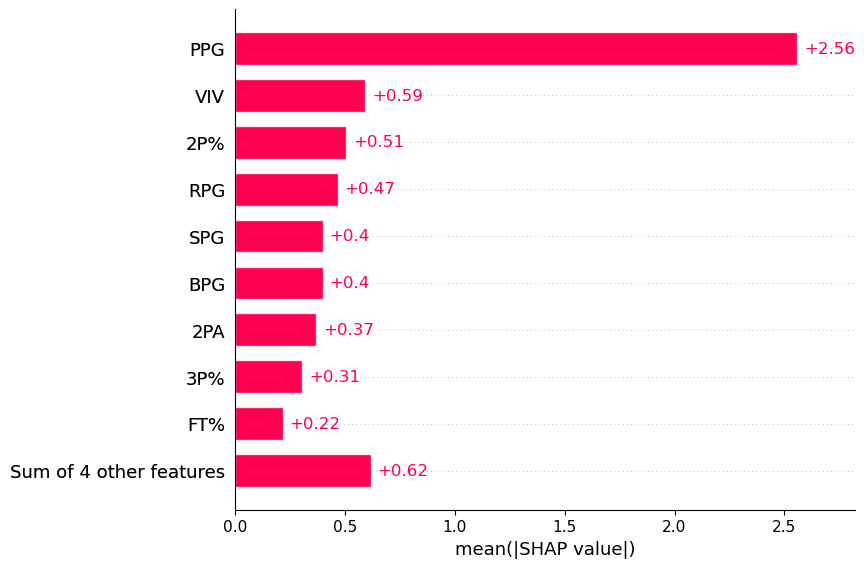

In [41]:
#SHAP chart
explainer = shap.TreeExplainer(XGBreg)
shap_values = explainer(x_train)
shap.plots.bar(shap_values)